# Read Light Curves

This notebook reads the light curve data from the `1_Light_Curves` directory using `h5py` and visualizes the results.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define file paths in the current directory
flux_path = 'flux-2channel.txt'
ferr_path = 'ferr-2channel.txt'
flux_white_path = 'flux-whitelight.txt'
err_white_path = 'ferr-whitelight.txt'
time_path = 'time.txt'

# Optional wavelength file (if present)
wavelength_candidates = ['wl.txt', 'wls.txt', 'wavelength.txt', 'wavelengths.txt']

print('Reading light-curve files from current directory:')
print(f'  time: {time_path}')
print(f'  flux: {flux_path}')
print(f'  ferr: {ferr_path}')
print(f'  white flux: {flux_white_path}')
print(f'  white ferr: {err_white_path}')

Reading light-curve files from current directory:
  time: time.txt
  flux: flux-2channel.txt
  ferr: ferr-2channel.txt
  white flux: flux-whitelight.txt
  white ferr: ferr-whitelight.txt


In [3]:
# Read data from text files in the current directory
time = np.loadtxt(time_path)
flux_raw = np.loadtxt(flux_path)
ferr_raw = np.loadtxt(ferr_path)
flux_white = np.loadtxt(flux_white_path)
err_white = np.loadtxt(err_white_path)

# Ensure spectral arrays are 2D: (time, channel)
if flux_raw.ndim == 1:
    flux_raw = flux_raw[:, None]
if ferr_raw.ndim == 1:
    ferr_raw = ferr_raw[:, None]

# Optional wavelength centers from file; otherwise use channel indices
wls = None
for cand in wavelength_candidates:
    if os.path.exists(cand):
        wls = np.loadtxt(cand)
        print(f'Using wavelength file: {cand}')
        break

if wls is None:
    wls = np.arange(1, flux_raw.shape[1] + 1, dtype=float)
    print('No wavelength file found (wl.txt / wls.txt / wavelength*.txt).')
    print('Using channel indices for wls:', wls)

# Build a time mask that removes cadences with NaN/inf in ANY spectral bin
if flux_raw.ndim != 2:
    raise ValueError(f"Expected 2D spectral flux array, got shape {flux_raw.shape}")

# Determine which axis corresponds to time
if flux_raw.shape[0] == time.shape[0]:
    time_axis = 0
elif flux_raw.shape[1] == time.shape[0]:
    time_axis = 1
else:
    raise ValueError(
        f"Cannot align spectral flux with time. flux shape={flux_raw.shape}, time len={time.shape[0]}"
    )

collapse_axis = 1 - time_axis
bad_time_flux = np.any(~np.isfinite(flux_raw), axis=collapse_axis)
bad_time_ferr = np.any(~np.isfinite(ferr_raw), axis=collapse_axis)
bad_time_white = ~np.isfinite(flux_white) | ~np.isfinite(err_white)

bad_time = bad_time_flux | bad_time_ferr | bad_time_white
good_time = ~bad_time

# Apply the SAME time mask to all light-curve arrays
if time_axis == 1:
    flux = flux_raw[:, good_time].T
    ferr = ferr_raw[:, good_time].T
else:
    flux = flux_raw[good_time, :]
    ferr = ferr_raw[good_time, :]

time = time[good_time]
flux_white = flux_white[good_time]
err_white = err_white[good_time]

print(f"Masked bad cadences: {np.sum(bad_time)} / {bad_time.size}")

# Optional: keep only two secondary eclipses and mask the rest
use_two_secondary_only = False
porb_mask = 0.81347406
t0_transit_ref = 55934.29223313741
secondary_half_width_days = 0.06
secondary_cycles_to_keep = None  # e.g. set to [0, 1] to force specific cycles

if use_two_secondary_only:
    tsec_ref = t0_transit_ref + 0.5 * porb_mask
    cycle_index = np.round((time - tsec_ref) / porb_mask).astype(int)
    unique_cycles = np.unique(cycle_index)

    if secondary_cycles_to_keep is None:
        cycle_med = (np.median(time) - tsec_ref) / porb_mask
        order = np.argsort(np.abs(unique_cycles - cycle_med))
        keep_cycles = np.sort(unique_cycles[order[:2]])
    else:
        keep_cycles = np.array(secondary_cycles_to_keep, dtype=int)

    keep_mask = np.zeros_like(time, dtype=bool)
    for cyc in keep_cycles:
        t_center = tsec_ref + cyc * porb_mask
        keep_mask |= np.abs(time - t_center) <= secondary_half_width_days

    time = time[keep_mask]
    flux_white = flux_white[keep_mask]
    err_white = err_white[keep_mask]
    flux = flux[keep_mask, :]
    ferr = ferr[keep_mask, :]

    print(f"Keeping only two secondary eclipses: cycles={keep_cycles.tolist()}")
    print(f"Cadences kept after eclipse mask: {np.sum(keep_mask)}")

No wavelength file found (wl.txt / wls.txt / wavelength*.txt).
Using channel indices for wls: [1. 2.]
Masked bad cadences: 0 / 4498


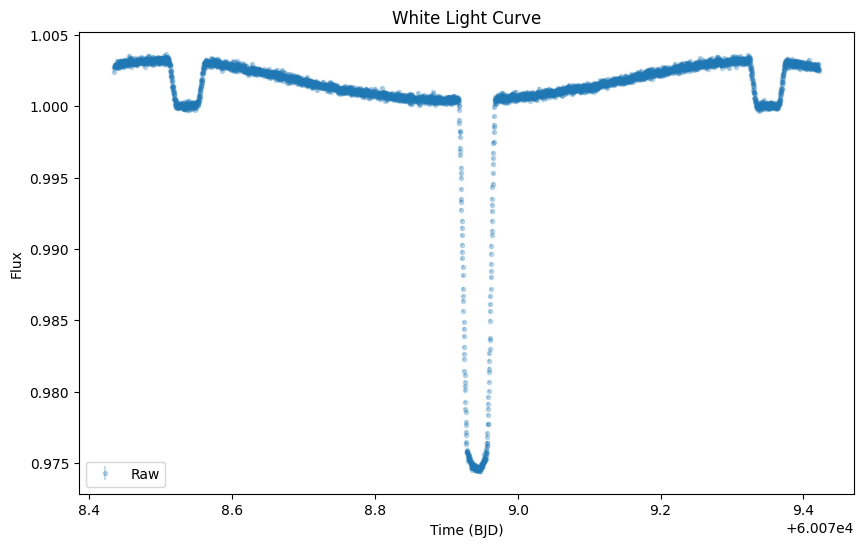

In [4]:
# Plot the White Light Curve (raw + baseline + corrected)
plt.figure(figsize=(10, 6))
if 'flux_white' in globals():
    plt.errorbar(time, flux_white, yerr=err_white, fmt='.', alpha=0.25, label='Raw')
plt.title(f'White Light Curve')
plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [5]:
np.savez('WASP43b_NIRSpec.npz', time=time, flux_white=flux_white, flux_err_white=err_white, flux=flux, flux_err=ferr, wl=wls, flux_white_raw=flux_white, flux_err_white_raw=err_white, flux_raw=flux_raw, flux_err_raw=ferr)

In [ ]:
time, flux_white, flux_err_white, flux, flux_err, wl, flux_white_raw, flux_err_white_raw, flux_raw, flux_err_raw = np.load('WASP43b_NIRSpec.npz').values()

In [7]:
# mask = flux_white > 0.99
# time = time[mask]
# flux_white = flux_white[mask]
# err_white = err_white[mask]

In [8]:
# # Plot Spectral Light Curves for a few wavelengths
# plt.figure(figsize=(12, 8))

# # Plot first, middle, and last wavelength channels
# indices = [0, len(wavelength)//2, len(wavelength)-1]

# for i in indices:
#     plt.plot(time, flux[i], '.', alpha=0.5, label=f'{wavelength[i]:.2f} $\mu$m')

# plt.title('Spectral Light Curves')
# plt.xlabel('Time (BJD)')
# plt.ylabel('Flux')
# plt.legend()
# plt.show()

In [9]:
# Star Parameters (Source: S5_WASP-43b_fitpar_starry_white.epf / Nature Astronomy 2024)
m_star = 0.6916
m_planet = 2.034 * 1.898e27 / 1.98847e30
R_sun = 6.957e8  # Radius of Sun in meters
R_J = 6.9911e7  # Radius of Jupiter in meters

r_star = 0.665
r_planet = 1.049 * R_J / R_sun
A = dict(
    ydeg=1,  
    udeg=2,  
    inc=90,  
    amp=1.0, 
    r=r_star, 
    m=m_star, 
    prot=100.0,
    u=[0.044, 0.27],  # u1, u2 from epf file
)

# Planet Parameters (WASP-43b)
porb = 0.81347406 # Period from epf file
t0_ref = 55934.2922503 # BJD from epf file (55934 + 2400000.5)

# t0_ref = 55934 + 2400000.5

B = dict(
    ydeg=6,
    udeg=2,
    inc=82.155,  # inc from epf file
    r=r_planet,
    m=m_planet,  # Mass often negligible for light curve geometry (setting to 0 or keeping small)
    porb=porb,
    prot=porb,
    t0=t0_ref,
    u=[0.0, 0.0], # Planet LD usually ignored or 0
    Omega=0,
    ecc=0.0,
    w=90, # Argument of periastron from epf file
)  

print(f"Using T0: {B['t0']}")
print(f"Using Period: {B['porb']}")

Using T0: 55934.2922503
Using Period: 0.81347406


In [10]:
import starry
from spectralmap.mapping import Map
starry.config.lazy = False
starry.config.quiet = True
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sec = starry.Secondary(
    starry.Map(ydeg=4, udeg=B["udeg"], inc=90), # planet inclination
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"], # time of transit
    inc=B["inc"],
    theta0=180,  # phase offset in degrees
)

In [13]:
from spectralmap.mapping import make_maps

maps = make_maps(mode='eclipse', pri=pri, sec=sec, map_res=30, ydegs=np.arange(2, 6, 1), lambdas=np.logspace(7, 12, 10), eclipse_depth=0.0045)
maps.a_lambda = 1.5
maps.b_lambda = 1e-10
from spectralmap.mapping import LightCurveData
data = LightCurveData(theta = time, flux=np.array([flux_white]), flux_err=np.array([flux_err_white]), wavelength=np.array([0.65]))
w_all, I_white, I_cov_white = maps.marginalized_maps(data)

lambda:  10%|█         | 1/10 [00:09<01:26,  9.64s/it]

lambda=10000000.0: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 1, ydeg=4: 0, ydeg=5: 0


lambda:  20%|██        | 2/10 [00:19<01:15,  9.49s/it]

lambda=35938136.63804626: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 1, ydeg=4: 0, ydeg=5: 0


lambda:  30%|███       | 3/10 [00:30<01:11, 10.18s/it]

lambda=129154966.50148827: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 1, ydeg=4: 0, ydeg=5: 0


lambda:  40%|████      | 4/10 [00:42<01:06, 11.09s/it]

lambda=464158883.3612773: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0


lambda:  50%|█████     | 5/10 [00:56<01:00, 12.04s/it]

lambda=1668100537.2000558: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0


lambda:  60%|██████    | 6/10 [01:06<00:45, 11.28s/it]

lambda=5994842503.189421: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0


lambda:  70%|███████   | 7/10 [01:16<00:33, 11.02s/it]

lambda=21544346900.318867: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  80%|████████  | 8/10 [01:29<00:23, 11.52s/it]

lambda=77426368268.11278: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  90%|█████████ | 9/10 [01:42<00:11, 11.98s/it]

lambda=278255940220.7126: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda: 100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


lambda=1000000000000.0: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0
Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 1, ydeg=4: 0, ydeg=5: 0


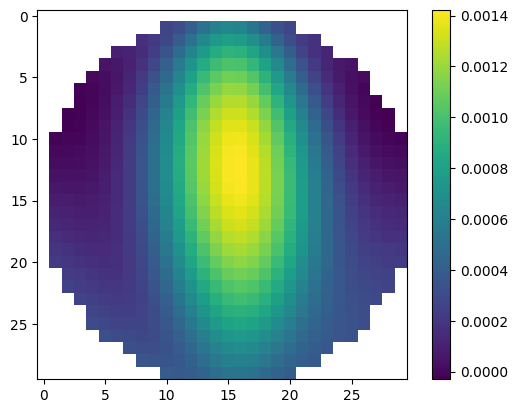

In [14]:
from spectralmap.mapping import expand_moll_values

plt.imshow(expand_moll_values(I_white, maps.moll_mask_flat).reshape(30, 30))
plt.colorbar()

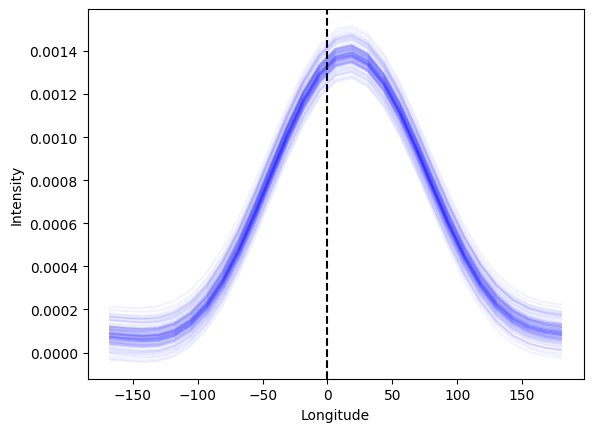

Text(0, 0.5, 'Intensity')

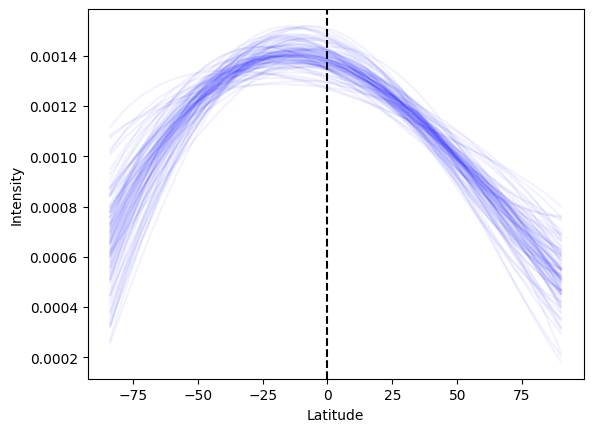

In [15]:
I_plot = I_white[0]
I_cov_plot = I_cov_white[0]
N = 100
samples = np.random.multivariate_normal(I_plot, I_cov_plot, N)

n_lat, n_lon = maps.map_res, maps.map_res
lons, lats = np.linspace(-180, 180, n_lon), np.linspace(-90, 90, n_lat)

for i in range(N):
    plt.plot(lons, expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[n_lat//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Longitude')
plt.ylabel('Intensity')

plt.show()
for i in range(N):
    plt.plot(lats, expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[:, n_lon//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Latitude')
plt.ylabel('Intensity')

In [ ]:
from spectralmap.cluster import find_clusters

amplitudes = np.ones(I_all_wl.shape[0])  # Placeholder for actual amplitude scaling per wavelength
F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)
F_all_wl[F_all_wl<0] = 1e-6

F_regionals, F_regional_errs, labels = find_clusters(
    F_all_wl,
    F_cov_all_wl,
    n_corners=4,
    n_neighbors=100,
 )



print('F_regionals shape:', F_regionals.shape)
print('F_regional_errs shape:', F_regional_errs.shape)
print('labels unique (full map):', np.unique(labels))

In [16]:
import numpy as np
from scipy.optimize import leastsq

# Physical Constants
c = 2.998e8   # Speed of light values from ExFig3.py
h = 6.626e-34 # Planck constant
kb = 1.381e-23 # Boltzmann constant

# Load throughput data once globally to avoid reading file in loops
try:
    throughput_data = np.loadtxt('../eigenspectra/ExFig3/niriss_order1.txt')
except OSError:
    print("Warning: Throughput file not found. Ensure path is correct.")
    throughput_data = None

def planck_radiance(wavelength_microns, temperature):
    """Calculates Blackbody radiance B_lambda in W/m^2/sr/m"""
    waves_m = wavelength_microns * 1e-6
    # Planck's Law
    bb = (2 * h * c**2 / waves_m**5) / (np.exp(h * c / (waves_m * kb * temperature)) - 1)
    return bb

def integrate_throughput(wavelength_microns, spectrum, throughput):
    """Integrates a spectrum over a bandpass defined by throughput."""
    # Normalize throughput to calculate the weighted mean flux
    denom = np.trapz(throughput, wavelength_microns)
    if not np.isfinite(denom) or np.isclose(denom, 0.0):
        return np.nan
    norm_throughput = throughput / denom
    integrated_val = np.trapz(spectrum * norm_throughput, wavelength_microns)
    return integrated_val

def calc_instrument_throughput(waves):
    """Interpolates throughput to given wavelengths using pre-loaded data."""
    if throughput_data is None:
        # Fallback or error if data not loaded
        return np.ones_like(waves)
    return np.interp(waves, throughput_data[:,0], throughput_data[:,1])

def residuals(T, target_radiance, wavelength_grid, throughput):
    """Residual function for the optimizer."""
    model_flux = planck_radiance(wavelength_grid, T)
    model_integrated = integrate_throughput(wavelength_grid, model_flux, throughput)
    return target_radiance - model_integrated

def compute_bin_widths_from_centers(central_waves):
    """Compute non-zero bin widths from bin centers using midpoint edges."""
    central_waves = np.asarray(central_waves)
    if central_waves.size < 2:
        return np.array([1e-6], dtype=float)
    edges = np.empty(central_waves.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (central_waves[:-1] + central_waves[1:])
    edges[0] = central_waves[0] - 0.5 * (central_waves[1] - central_waves[0])
    edges[-1] = central_waves[-1] + 0.5 * (central_waves[-1] - central_waves[-2])
    widths = np.diff(edges)
    widths = np.where(widths > 0, widths, np.min(widths[widths > 0]))
    return widths

def eclipse_depth_to_brightness_temp(central_waves, bin_widths, eclipse_depth, r_p_r_s, T_star=6400.0):
    """
    Converts Eclipse Depth to Brightness Temperature element-wise.
    Optimized to pre-calculate grid integrations per wavelength bin.
    """
    
    eclipse_depth = np.asarray(eclipse_depth)
    central_waves = np.atleast_1d(central_waves)
    bin_widths = np.atleast_1d(bin_widths)
    
    temps = np.zeros_like(eclipse_depth)
    initial_guess = [2500.0]
    
    n_waves = len(central_waves)
    
    # Case 1: Multiple spectra (Regions x Wavelengths)
    if eclipse_depth.ndim == 2:
        n_regions = eclipse_depth.shape[0]
        # Iterate over wavelengths (outer loop)
        for i_wav in range(n_waves):
            cw = central_waves[i_wav]
            dw = bin_widths[i_wav]
            
            # --- Pre-calculation for this bin ---
            wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
            throughput_grid = calc_instrument_throughput(wave_grid)
            
            star_bb = planck_radiance(wave_grid, T_star)
            star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
            # ------------------------------------

            # Iterate over regions (inner loop) - only solving remains
            for i_reg in range(n_regions):
                depth = eclipse_depth[i_reg, i_wav]
                planet_int = star_int * depth / r_p_r_s**2
                if not np.isfinite(planet_int):
                    temps[i_reg, i_wav] = np.nan
                    continue

                res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
                temps[i_reg, i_wav] = res[0][0]
                
    # Case 2: Single spectrum (Wavelengths only)
    elif eclipse_depth.ndim == 1:
        for i_wav in range(n_waves):
            cw = central_waves[i_wav]
            dw = bin_widths[i_wav]
            depth = eclipse_depth[i_wav]
            
            wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
            throughput_grid = calc_instrument_throughput(wave_grid)
            
            star_bb = planck_radiance(wave_grid, T_star)
            star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
            
            planet_int = star_int * depth / r_p_r_s**2
            if not np.isfinite(planet_int):
                temps[i_wav] = np.nan
                continue
            
            res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
            temps[i_wav] = res[0][0]
            
    # Case 3: Scalar
    else:
        cw = central_waves[0]
        dw = bin_widths[0]
        depth = eclipse_depth
        wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
        throughput_grid = calc_instrument_throughput(wave_grid)
        star_bb = planck_radiance(wave_grid, T_star)
        star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
        planet_int = star_int * depth / r_p_r_s**2
        if not np.isfinite(planet_int):
            return np.nan
        res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
        return res[0][0]

    return temps

# --- Example Usage ---
RpRs = 0.09783 # From ExFig3.py
print("F_regionals shape:", F_regionals.shape)
print("F_regionals mean:", np.mean(F_regionals))

# Fix applied: Convert Starry Intensity to Eclipse Depth (Flux)
# Starry Intensity I integrates to Flux F = pi * I on the unit disk
# The conversion function expects Flux (Eclipse Depth), so we multiply by pi.
dlam = compute_bin_widths_from_centers(wls)
print("First three dlam:", dlam[:3])
Tb_all = eclipse_depth_to_brightness_temp(wls, dlam, F_regionals, RpRs)
Tb_upper_all = eclipse_depth_to_brightness_temp(wls, dlam, (F_regionals + F_regional_errs), RpRs)
Tb_lower_all = eclipse_depth_to_brightness_temp(wls, dlam, (F_regionals - F_regional_errs), RpRs)
print("Tb_all shape:", Tb_all.shape)
print("Tb_all mean:", np.mean(Tb_all))
base_colors = ['#BBBBBB', '#D62728', '#1F77B4', '#9467BD', '#2CA02C', '#FF7F0E', '#8C564B']
for i in range(len(Tb_all)):
    plt.plot(wls, Tb_all[i], color=base_colors[i % len(base_colors)], label=f'Region {i+1}')
    plt.fill_between(wls, Tb_lower_all[i], Tb_upper_all[i], color=base_colors[i % len(base_colors)], alpha=0.3)
plt.grid()
plt.xlabel('Wavelength (microns)')
plt.ylabel('Brightness Temperature (K)')

NameError: name 'F_regionals' is not defined